# Yelp - analyse restaurant networks, user reviews and ratings and plot user-business networks. Derive sentimental score from the reviews and provide lead user experience

## Why Yelp Dataset?

Yelp users give ratings and write reviews about businesses and services on Yelp. These reviews and ratings help other Yelp users to evaluate a business or a service and make a choice. Ratings are not only useful to convey the overall experience, they also convey the context which led a reviewer to that experience. 

Yelp published more than 4.5 million crowd-sourced reviews. As of 2016 has 135 million monthly visitors and 95 million reviews.User community active in major metropolitan areas in US and Europe. Has pages for individual locations e.g. restaurants or schools. Users can submit review on products or services and a rating of 1-5 *

Dataset we have chosen is of ~3GB. We have reduced the dataset by randomly selecting 1/10th Datapoints.

Using this data objective is to: 
* analyse restaurant-user network
* derive the sentimental score using NLP and then combine star ratings with sentimental score to derive a new rating system:
    * Sentiment score/business
    * New experience
* analyse how much this new rating differs from the stars rating as provided by users
* early birds and average score for every business
    * Reducing dataset
    * degree distribution/analysis
* look at trends to identify 
    * the highest score for restaurant and 
    * the highest evolution for a category
* provide a personalized experience to users by sharing information on what other restaurants could suit their cuisine expectations, taste and experience


## Dataset Investigation -

In [1]:
# Including the libraries required for data analysis
%matplotlib inline
from collections import Counter
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random

As part of analysis a subset of the overall dataset which is for Pennslyvania (PA) state has been considered. However, the approach that will be followed follow through out this project could be applied to the entire dataset and similar analysis could be performed.

In [3]:
#Path for business and review datasets for Pennsylvania (PA) state
file_PA_business = 'Data_State/PA/business.json'
file_PA_review = 'Data_State/PA/review.json'

In [4]:
##Creating a dataframe for the business file
df_PA_bus = pd.read_json(file_PA_business)

#Review file can't be loaded by read_json, hence the below method is used instead.

with open(file_PA_review) as f:
    data = json.load(f)
df_PA_re = pd.DataFrame(data)

In [46]:
#Printing a preview of the business file attributes
df_PA_bus.head(1)

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,"{u'Take-out': True, u'Drive-Thru': False, u'Go...",5UmKMjUEUNdYWqANhGckJw,"[Fast Food, Restaurants]",Dravosburg,"4734 Lebanon Church Rd\nDravosburg, PA 15034","{u'Thursday': {u'close': u'21:00', u'open': u'...",40.354327,-79.900706,Mr Hoagie,[],True,7,3.5,PA,business


In [36]:
#Printing the shape size of the dataframe. This provides the dimension for the business dataframe.
print(df_PA_bus.shape)

(4086, 15)


In [37]:
#Printing a preview of the review file attributes.
df_PA_re.head(1)

,business_id,date,review_id,sentiment,stars,text,type,user_id,votes
0,5UmKMjUEUNdYWqANhGckJw,2012-08-01,Ya85v4eqdd6k9Od8HbQjyA,4.991,4,"Mr Hoagie is an institution. Walking in, it do...",review,PUFPaY9KxDAcGqfsorJp3Q,"{u'funny': 0, u'useful': 0, u'cool': 0}"


In [30]:
#Printing the shape size of the dataframe. This provides the dimension for the reviews dataframe.
print(df_PA_re.shape)

(111542, 9)


In [5]:
#Creating a list that contains both business id and name in a zip. Extracting the business id and name for later.
business_id_vs_name = []
for row in df_PA_bus.itertuples():
    business_id_vs_name.append((row[2],row[9]))

#Creating a list that contains every business hit in the review file. 
#Extracting all reviews from reviews frame for the business id
business_hit = []
for business in df_PA_re['business_id']:
    business_hit.append(business)

#Using Counter to count the frequency of a business in business_hit.

count_business_hit = Counter(business_hit)
print 'Business name','\t\t\t','Hits\n'
for business in count_business_hit.most_common(10):
    for pair in business_id_vs_name:
        if business[0] == pair[0]:
            business_name = pair[1]
    if len(business_name) > 20:
        print business_name,'\t', business[1]
    elif len(business_name) > 14:
        print business_name,'\t\t', business[1]
    elif len(business_name) > 10:
        print business_name,'\t\t\t', business[1]

Business name 			Hits

Meat & Potatoes 		1096
Primanti Bros. 			836
Gaucho Parrilla Argentina 	826
Church Brew Works 		652
Fat Heads Saloon 		505
Primanti Bros. 			425
Sienna Mercato 			425
Point Brugge Café 		420


In [6]:
#Creating a list that contains every user hit in the review file. Extracting user id from reviews Dataframe.
user_hit = []
for user in df_PA_re['user_id']:
    user_hit.append(user)

#Using Counter to count the frequency of a user in user_hit

count_user_hit = Counter(user_hit)
print 'User_id','\t\t\t','Hits\n'
for user in count_user_hit.most_common(10):
    print user[0],'\t\t',user[1]

User_id 			Hits

nEYPahVwXGD2Pjvgkm7QqQ 		610
iTmWHtltCtk0Gm55AOxrUA 		461
WzaaorVCmUTQvu4mScunNg 		385
9cCTmiJ7hz35rHIdr8n9kA 		377
9OZH1Ecw-qUkCW5MS0NefA 		372
UD7Y1CqfY6mDmRwIuCf6nA 		366
J_q8jN623uew8ZzMChXBCA 		346
_vS9qNQvx8wVUOIkj4qfAg 		345
So32N7bSbUd1RwhFtI6jTQ 		321
RSExP0-Boucr4QyIEzZi0A 		282


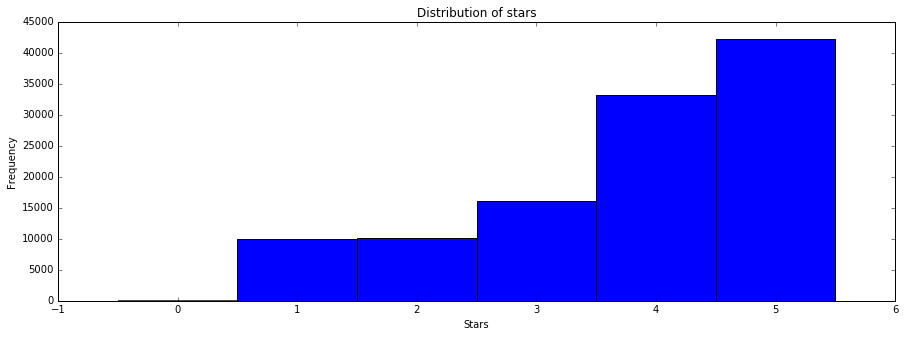

In [39]:
#Show the stars distribution. Using the stars provided in reviews and generating its frequency plot.
# Results show that 5 stars have the highest frequency and 1 star has the lowest frequency which is interesting.
bins=np.arange(0,5+2,1)
plt.figure(figsize=(15,5))
plt.hist(df_PA_re['stars'],bins=bins,align='left')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('Distribution of stars')
plt.show()

### Plotting the Degree Distribution for Business - Frequency of number of reviews received for business

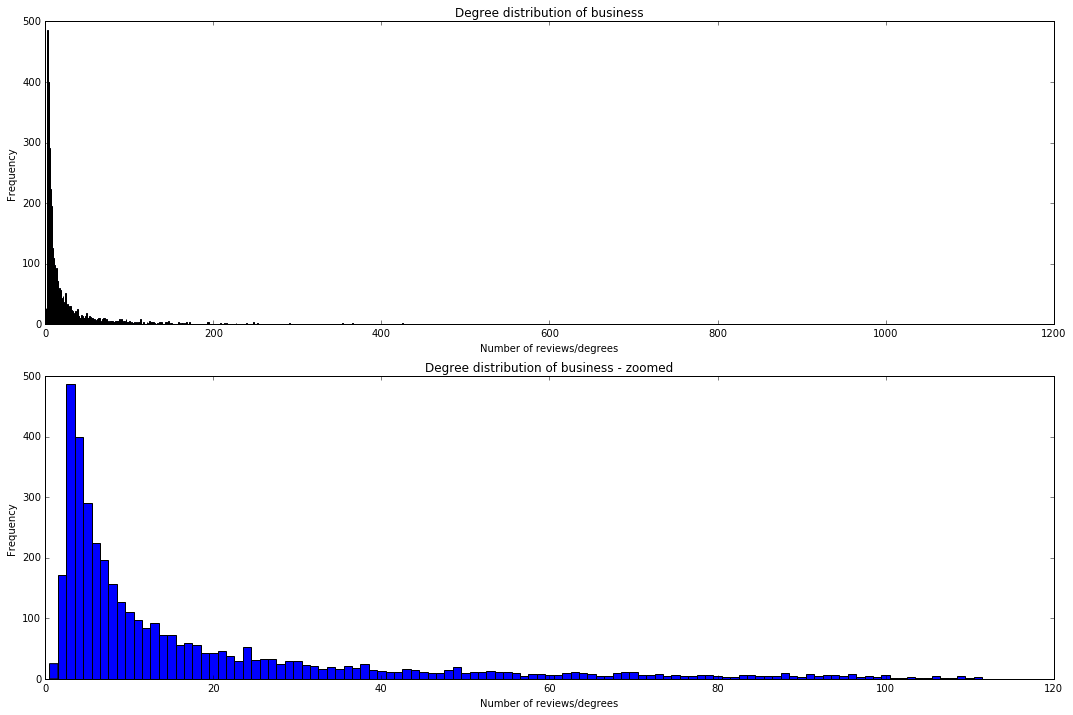

In [40]:
#sort count_business_hit based on value.
sorted_count_business_hit = sorted(count_business_hit.items(), key=lambda x: x[1], reverse=True)

business_degree = []
for pair in sorted_count_business_hit:
    business_degree.append(pair[1])

plt.figure(figsize=(15,10))
#Degree distribution
plt.subplot(2,1,1)
n = max(business_degree)
bins = np.arange(min(business_degree),n+2,1)
plt.hist(business_degree,bins=bins,align='left')
plt.title('Degree distribution of business')
plt.xlabel('Number of reviews/degrees')
plt.ylabel('Frequency')

#Degree distribution - zoomed
plt.subplot(2,1,2)
n1 = max(business_degree[200:])
bins = np.arange(min(business_degree[200:]),max(business_degree[200:])+2,1)
plt.hist(business_degree[200:],bins=bins,align='left')
plt.title('Degree distribution of business - zoomed')
plt.xlabel('Number of reviews/degrees')
plt.ylabel('Frequency')
plt.tight_layout()

From the above plot for business, it is interesting to see that there are very few businesses (around 100) that have more than 1 review. Majority of the other businesses have 1 or no reviews.

### Plotting the Degree Distribution for User - Frequency of number of reviews

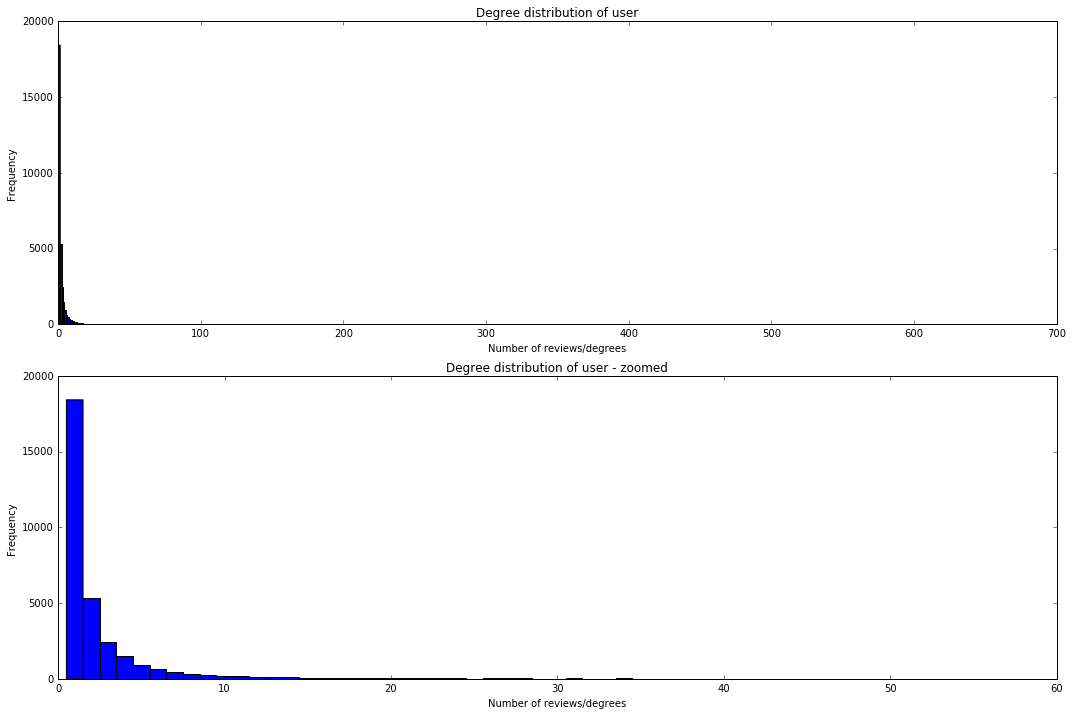

In [16]:
sorted_count_user_hit = sorted(count_user_hit.items(), key=lambda x: x[1], reverse=True)

user_degree = []
for pair in sorted_count_user_hit:
    user_degree.append(pair[1])

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
n = max(user_degree)
bins = np.arange(min(user_degree),n+2,1)
plt.hist(user_degree,bins=bins,align='left')
plt.title('Degree distribution of user')
plt.xlabel('Number of reviews/degrees')
plt.ylabel('Frequency')

plt.subplot(2,1,2)
n1 = max(user_degree[200:])
bins = np.arange(min(user_degree[200:]),max(user_degree[200:])+2,1)
plt.hist(user_degree[200:],bins=bins,align='left')
plt.title('Degree distribution of user - zoomed')
plt.xlabel('Number of reviews/degrees')
plt.ylabel('Frequency')
plt.tight_layout()

From the above plot for user reviews, it is interesting to see that there are few reviewers who have posted multiple reviews. We have maximum reviewers with 1 or less than 10 reviews.

## Tools, theory and analysis

LabMT wordlist has been used to perform Sentimental Analysis for the reviews and generating a rating for each review. 

The new rating is a function of the star rating provided to restaurant and the sentimental score for the review provided by the same user to the same restaurant

In the journey to find a corelation it was interesting to see that a star rating of 4 has a strong corelation with an equivalent sentimental score. However, for a star rating of 5, its equivalent sentimental score is low indicating that the user gave a high rating but his reviews were not equally positive for the restaurant.

For Network analysis networkx library has been used to built an weighted network connecting users with restaurants through the reviews shared by users.

A weighted network connecting users to restaurants based on the sentimental score of the reviews was created and a weight was assigned to each link.  Based on this network , goal was to identify restaurants that have a higher weighted link but are not rated by the user and sharing this info with the user as lead information e.g. - "You may be interested in these restaurants".

### Sentimental score

A review is mainly composed of a number of stars and a text attached, and the global score of a restarant is based only on the average number of stars. But some people give 5\* more easily than other, and only the text can give a real insight of the actual feeling of a user for a restaurant.

One idea then is to build a function that analyses the global sentiment of a text review. One easy way to do so is to extract the words associated with a sentiment, positive and negative, and return the average "sentimental value", or sentimental score as we will call it.

As stated before, we will use the labMT wordlist as our sentiment reference.

In [2]:
import csv

#Open the wordlist and create a dict associated
with open('labMT.txt','r') as fi:
    #Get a dtict of the words and the sentiment value associated
    labMT = csv.reader(fi, delimiter = '\t')
    labMT = {x[0]:x[2] for x in labMT}

print len(labMT)

10222


In [2]:
def Sentiment(tok):
    """Returns the average sentiment score of a given text"""
    sentiment = 0    #Returned value
    n = 0 #number of words with sentiment attached
    for word in tok:
        try:
            #if the word is found in te list, append its value
            sentiment += float(labMT[word])
            n += 1
        except:
            pass    
    try:
        #If no word found (n=0), raise an error
        return sentiment / n
    except:
        return float('nan') #No word with sentiment attached in the text

This gives typically scores around 4.5-5.5. Then we ran this function for every review of the dataset and added it as a value in the json file under the attribute "sentiment".

In [4]:
import json

with open('./Data_State/PA/review.json') as fi:
    data = json.load(fi)
    
print len(data)

111542


In [11]:
print data[2]['sentiment'], data[2]['stars']
print data[2]['text']
print
print data[350]['sentiment'], data[350]['stars']
print data[350]['text']

4.967 5
Yes this place is a little out dated and not opened on the weekend. But other than that the staff is always pleasant and fast to make your order. Which is always spot on fresh veggies on their hoggies and other food. They also have daily specials and ice cream which is really good. I had a banana split they piled the toppings on. They win pennysaver awards ever years i see why.

4.959 1
I've never posted a yelp review before.  This meal was so horrible that I downloaded the yelp app just so I could warn others to stay away!  We ordered food from Capri since we were going to voodoo brewery.  We ordered a cheesesteak with no mayo and an Italian calzone since the person working there talked up the calzones.  We ended up with a cheesesteak heavy on the mayo and an Italian wedgie, which was just a folded up pizza full of mayo and onions.  No sign of Italian meat to be found.  No marinara sauce.  It was inedible.  We ended up walking to kfc instead.  

I want to leave a zero star rat

As we can see, the sentimental score is quite well related to the actual text review, but the difference between two score is relatively small. We will analyse these variations now with basic stats on that attribute.

One can also point that for these two examples, the stars gave a pretty good idea of the review, although with less nuances than the sentimental score. We will investigate if this trend is generalised.

For this analysis, we will only keep the reviews with an actual score (not a NaN value), in order not to process the reviews in other languages or one-word reviews (they actually represent 20 reviews over the 111,000).

In [15]:
sentiment = []
star = []

for ii in data:
    #Don't add the NaN values
    if ii['sentiment'] == ii['sentiment']:
        sentiment += [ii['sentiment']]
        star += [ii['stars']]

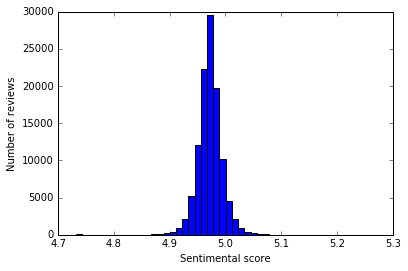

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.hist(sentiment, bins = 50)
plt.xlabel("Sentimental score")
plt.ylabel("Number of reviews")
plt.show()

In [20]:
import numpy as np

#Print the average and the std for the scores
sentMean = np.mean(sentiment)
sentStd = np.std(sentiment)

print "Average sentimental score: ", sentMean
print "Standard deviation: ", sentStd

Average sentimental score:  4.97175664602
Standard deviation:  0.0221201249578


What we can see from this plot is that the sentimental score is fairly well distributed around the average value, and the variations are really small but still exists. So considering the standard deviation, the relatively small difference of score between the two examples above is logical.

For a better vizualisation of the data, we will now use the normalized values of the sentimental score.

In [21]:
starDictNorm = {}

#Create a dictionnary of all normalized scores for reviews with a certain number of stars
for i in set(star):
    starDictNorm[i] = [((sentiment[x] - sentMean) / sentStd) for x in range(len(star)) if star[x] == i]

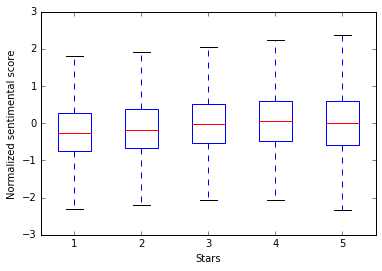

In [22]:
#Boxplot to see the correlation between stars and scores
plt.boxplot([starDictNorm[i] for i in starDictNorm.keys()],0,'')
plt.xlabel('Stars')
plt.ylabel('Normalized sentimental score')
plt.show()

We can see from this boxplot that the sentimental score follows the general trend of the stars, but with a lot more of nuance. It has to be noticed that the outliers were not plotted since shorter reviews may have really strong scores compared to longer ones.

However, it does not seem true for the 5\* reviews. One of the explanations is that there are more 5\* reviews than the other values. Another explanation can be that some people tend to give 5 stars anyways to not penalize the restaurant (since a 3\* review can be percieved as a "bad" review) even after not having a good or perfect experience at the restaurant. 

Thus, the sentimental score seems to be a more nuanced and accurate evaluation of the user's experience. For the rest of the analysis, we will keep only this value to evaluate the actual score of a review and forget about the stars. Although, this is an approximation and it could be improved by taking into account the stars and maybe other parameters.

## New experience

This section is about recommending new places to a user by creating a weighted network. The network will have every business as a node and each egde will increase in weight if it is between two business that a user like.

Meaning that every user network with the business that they like are 'added' on top on the weighted network and thereby increasing the weight of the links inclueded in their network.

After the weighted network is created, then we will create a function that gives a user the nodes with highest weighted edge that is a neighbour to his own network, those nodes which the user are most likely to enjoy.

In [7]:
#Finding all the unique users
unique_user = set()
for user in df_PA_re['user_id']:
    unique_user.add(user)

#making a dict where each user is the key and the value is a list containing the zips of business_id and given star.
dict_user_experience = {}
for row in df_PA_re.itertuples():
    temp_list = set()
    if row[8] in dict_user_experience:
        if row[4] > 4.97:
            temp_list = set(dict_user_experience[row[8]])
            temp_list.add(row[1])
            dict_user_experience[row[8]] = list(temp_list)
    else:
        if row[4] > 4.97:
            dict_user_experience[row[8]] = [row[1]]

            
print len(unique_user),len(dict_user_experience.keys()), len(dict_user_experience['RSExP0-Boucr4QyIEzZi0A'])

32134 20452 130


### Network

In [10]:
edge_list = []
for user in dict_user_experience:
    for pair in itertools.combinations(dict_user_experience[user],2):
        edge_list.append(pair)
len(edge_list)

625582

In [11]:
#Using Counter to see the top 10 business that
#have the strogest edge between them.
count_edge_list = Counter(edge_list)
for element in count_edge_list.most_common(10):
    print element
count_edge_list = list(count_edge_list.items())

((u'bwu0cUZfksuu-uzTPrrl2A', u'Q4ULAiIE2qCA4RYplCTrUQ'), 28)
((u'9ylfrWjdX6CltGs_Qcv7Ng', u'Q4ULAiIE2qCA4RYplCTrUQ'), 28)
((u'ihUWFwY0r3ApW5aZ4Aqf9Q', u'rcCGdKxMPJk4lCzZZ1i_bA'), 25)
((u'TRLMm_deLvlPNmGNqRxcow', u'Q4ULAiIE2qCA4RYplCTrUQ'), 25)
((u'9SPwF-vRgtuHxciFxv5YLA', u'cjD2yGRhT5yaSj_KP55Ptw'), 25)
((u'diAEN3I9fXcZgNFpA5vz4g', u'rcCGdKxMPJk4lCzZZ1i_bA'), 21)
((u'ihUWFwY0r3ApW5aZ4Aqf9Q', u'RjavzMXChoFWdsIZnfs5YQ'), 21)
((u'rfy_bJ5ad-gfVmMeqKtsyw', u'RhOTBt7ISr2rhXisSMLTSw'), 20)
((u'UXlGymo9AduQcq-Q-H16og', u'rcCGdKxMPJk4lCzZZ1i_bA'), 20)
((u'rfy_bJ5ad-gfVmMeqKtsyw', u'8zdeaK3PWDsr5Kq4UOuNSw'), 20)


In [12]:
#Creating the undirected network
unG = nx.Graph()

#Adding egdes based on the users' own network
for element in count_edge_list:
    unG.add_edge(element[0][0],element[0][1], weight=element[1])

In [13]:
#printing the network dimensions - nodes, edges and total businesses
print len(unG.nodes()), len(unG.edges()), len(df_PA_bus)

3654 455806 4086


In [14]:
#checking the weight for an edge
unG.edges('bwu0cUZfksuu-uzTPrrl2A',data=True)[0][2]

{'weight': 1}

### Recommendation function

In [15]:
#Recommendation function which takes two inputs,
#user_id and number of recommendations.
def getRecommendation(user,n):
    list_recommendation = []
    for element in dict_user_experience[user]:
        for hit in unG.edges(element,data=True):
            if hit[1] not in dict_user_experience[user]:
                list_recommendation.append([hit[1],hit[2]['weight']])
    list_recommendation.sort(key=lambda tup: tup[1], reverse=True) #sort the list based on weight
    #changes the business with the name of the 
    #business.
    if len(list_recommendation) < n:
        for i in xrange(len(list_recommendation)):
            for row in df_PA_bus.itertuples():
                if row[2] == list_recommendation[i][0]:
                    list_recommendation[i][0] = row[9]
        return list_recommendation
    else:
        for i in xrange(n):
            for row in df_PA_bus.itertuples():
                if row[2] == list_recommendation[i][0]:
                    list_recommendation[i][0] = row[9]
        return list_recommendation[:n]

In [16]:
#Take a random user and print the top 5 recommendations
for pair in getRecommendation(random.choice(tuple(unique_user)), 5):
    print pair

[u'Ibiza Tapas & Wine Bar', 6]
[u'Seviche', 4]
[u'Silk Elephant', 4]
[u'Thai Place Restaurant', 3]
[u'Soba', 3]


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Super users identification

A final analysis of this dataset can help to identify super users, that is users that represent the best the whole Yelp user community. It can help Yelp to get better feedback from fewer people. 

So, we need to identify users that are close to the others, in other words the most central in the community by reviewing the same restaurants. Also, these users must be able to give the general feeling of the community for the restaurant.

### Closeness centrality

To do so, we will use the concept of closeness centrality in the graph, or closeness. This value represents the reciprocal of the sum of the distances between a given node (here, user), and the other nodes. The distance here will be the difference between its review and the average review for a restaurant, based on the sentimental score calculated above.

In [19]:
import json

#Extraction of the businesses
with open('./Data_State/PA/business.json') as fi:
    business = set([xx['business_id'] for xx in json.load(fi)])
print len(business)   

4086


Now two dictionnaries are created: one for the users and their reviews, the other for the businesses and their average sentimental score.

In [20]:
import numpy as np

userDict = {}
busDict = {}

with open('./Data_State/PA/review.json') as fi:
    review = [[xx['business_id'],xx['user_id'],xx['sentiment']] for xx in json.load(fi)]

for r in review:
    #List of the links and the scores
    try:
        userDict[r[1]] += [[r[0],r[2]]]
    except:
        userDict[r[1]] = [[r[0],r[2]]]
    
    #List of the sentiment scores
    try:
        busDict[r[0]] += [r[2]]
    except:
        busDict[r[0]] = [r[2]]
        
#Keep only the average score
for bb in busDict.keys():
    busDict[bb] = np.mean(busDict[bb])

Now the network will be created, with for each edge an attribute "difference". This attribute represent the difference between this user's point of view and the general opinion for that business.

In [21]:
import networkx as nx

G = nx.Graph()
i = 0
for uu in userDict.keys():
    i += 1
    for ll in userDict[uu]:
        #average score of the business
        avScore = busDict[ll[0]]
        #Don't add the links with no sentiment attached
        if ll[1] == ll[1] and avScore == avScore:
            G.add_edge(uu, ll[0], difference = abs(avScore - ll[1]))

In order to get only active users (and also to shorten the computation time), we will consider that a super user has to have reviewed at least 10 restaurants. It already gives a large base of user.

In [22]:
#Users with at least 10 reviews
activeUser = [xx for xx in userDict.keys() if len(userDict[xx])>=10]

print 'Number of active users: ', len(activeUser)
print 'Total number of users: ', len(userDict.keys())

Number of active users:  1781
Total number of users:  32134


Here is the actual computation of the closenss centrality for each node. This process is fairly long as we have a large number of users.

In [23]:
activeUserDict = {}
i = 0

for uu in activeUser:
    activeUserDict[uu] =  nx.closeness_centrality(G, u=uu, distance = 'difference')
    
    #This is just to keep track of the progress
    i += 1
    if i % 178 == 0:
        print round(i/float(len(activeUser)),2)
        
print 'done'

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
done


In [24]:
#Save the output
with open('lead_users_output.txt','w') as out:
    out.write(str(activeUserDict))

In [11]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Results analysis

As the analysis took quite some time and memory, we will reset the kernel and only use the values from the output text file.

In [25]:
with open('lead_users_output.txt') as fi:
    superUser = eval(fi.read())
    
print len(superUser)

1781


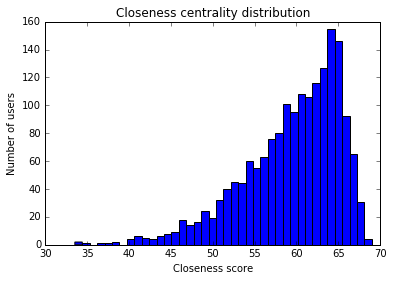

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(superUser.values(), bins = 40)
plt.title('Closeness centrality distribution')
plt.xlabel('Closeness score')
plt.ylabel('Number of users')
plt.show()

The histogram above shows the distribution of user considering the closeness centrality. Keep in mind that the higher the value is, the more central the user. The relatively abrupt decreasing in the end is only due to the small number of users with a lot of reviews.

So Now we will only focus on users with a closeness higher than 65 which seems to be a fairly high score, and try to see if the closeness centrality is only related to the number of reviews or if we managed to actually find super users.

Number of super user 267


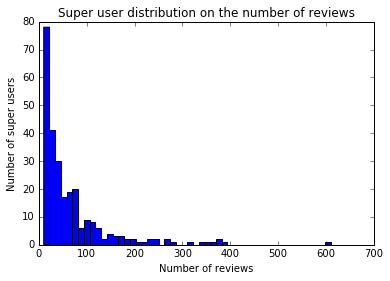

In [30]:
aaa = []
for xx in superUser.keys():
    if superUser[xx] > 65:
        aaa+= [len(userDict[xx])]
        
print 'Number of super user', len(aaa)

plt.hist(aaa, bins = 50)
plt.title('Super user distribution on the number of reviews')
plt.xlabel('Number of reviews')
plt.ylabel('Number of super users')
plt.show()

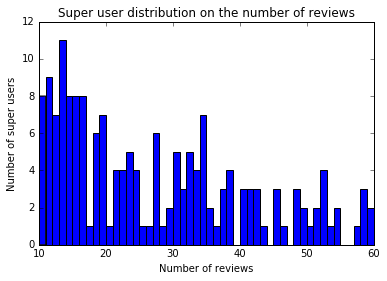

In [31]:
plt.hist(aaa, bins = 50,range = [10,60])
plt.title('Super user distribution on the number of reviews')
plt.xlabel('Number of reviews')
plt.ylabel('Number of super users')
plt.show()

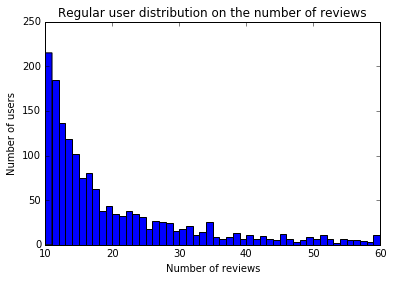

In [32]:
aaa = []
for xx in userDict.keys():
    aaa+= [len(userDict[xx])]

plt.hist(aaa, bins = 50, range=[10,60])
plt.title('Regular user distribution on the number of reviews')
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')
plt.show()

As a conclusion, we see that clearly the number of reviews has an impact on the closeness since almost every user with a particularly high nuber of reviews is a superuser, but we also identified super users with way less reviews: these users are particularly interesting for Yelp as they could even easily improve their score by giving more reviews.

## Discussion:

As part of the project, based on the objectives identified at the beginning, sentimental analysis of reviews, generating weighted network and performing network analysis to provide a lead user experience could be achieved.

There lies a scope to further analyse the network and the review comments to generate networks for different locations and then providing users with a comprehensive user experience based on the location a user may want to look for. Analysis could also be provided to the businesses on a comparison between the ratings they receive and the review and a list of users who are patrons of their business. This data could help businesses in providing special offers to these users and further building on the loyalty.